In [137]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torch import nn


from torch.utils.data.dataset import random_split

from torch import optim

import torch.nn.functional as F

import shutil


import numpy as np
import glob
import os
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score
from sklearn.decomposition import PCA

import datetime

%matplotlib inline
warnings.filterwarnings("ignore")
plt.rcParams['xtick.labelsize'] = 10

### Some functions

In [53]:
def calculate_auc_scores(y_test, y_prob, classes):
    auc_scores=[]
    for i in range(len(classes)):
        #prepare y_true as 1 if we have that class and 0 if not that class (other classes) - binarization
        y_true = [1 if y == i else 0 for y in y_test]
        auc_scores.append(roc_auc_score(y_true, y_prob[:,i]))

    return auc_scores

In [255]:
def plot_roc_curves_ovr(y_test, y_prob, classes, auc_scores):

    plt.figure(figsize=(9,5));

    colors=['b', 'g', 'r', 'c', 'm', 'y']

    for i in range(len(classes)):
        #prepare y_true as 1 if we have that class and 0 if not that class (other classes) - binarization
        y_true = [1 if y == i else 0 for y in y_test]
        fpr, tpr, _ = roc_curve(y_true, y_prob[:, i])

        sns.lineplot(x = fpr, y = tpr, label = classes[i]+ "  auc-score=%.4f" % auc_scores[i], color=colors[i]);
        plt.xlim(-0.05, 1.05);
        plt.ylim(-0.05, 1.05);
        plt.xlabel("False Positive Rate");
        plt.ylabel("True Positive Rate");

    sns.lineplot(x = [0, 1], y = [0, 1], color = 'blue', linestyle='--');

    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0));
    plt.title("Roc-curves for each class");
    plt.show();

In [102]:
def plot_precision_recall_curves(y_test, y_prob, classes):

    precision = dict()
    recall = dict()

    colors=['b', 'g', 'r', 'c', 'm', 'y']

    plt.figure(figsize=(9,5));
    for i in range(len(classes)):
        #prepare y_true as 1 if we have that class and 0 if not that class (other classes) - binarization of y_test
        y_true = np.array([1 if y == i else 0 for y in y_test])
        precision[i], recall[i], _ = precision_recall_curve(y_true,
                                                        y_prob[:, i])

        plt.plot(recall[i], precision[i], label=classes[i]+" auc-PR=%.4f" % auc(recall[i], precision[i]), color=colors[i]);

        baseline = len(y_true[y_true==1]) / len(y_true) # the fraction of that class in the whole dataset, the model which always predict that class will have such precision
        plt.plot([0, 1], [baseline, baseline], linestyle='--', color=colors[i], label=f'Baseline for {classes[i]}')

    plt.xlabel("recall");
    plt.ylabel("precision");
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0));
    plt.title("Precision vs. recall curve for each class");
    plt.show();

In [115]:
train_path = "Classification_data/train/"
test_path = "Classification_data/test/"

#dirrectory for validation set. I will save there 20% images from the train set and use it for validation
val_path = 'Classification_data/validation/'

In [108]:
class2ind = {}
ind2class = {}

In [109]:
#prepare index to class dictionary
for i, folder in enumerate(os.listdir(train_path)):
   ind2class[i]=folder

In [110]:
#prepare class to index dictionary
class2ind={ind2class[i]: i  for i in range(len(ind2class))}

In [111]:
class2ind

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

I will resize images to 50% of original width and height, to make the feature space smaller.

In [112]:
def get_data(path):
    data = []
    labels = []
    for folder in glob.glob(path + '/*'):
        for filename in glob.glob(folder + "/*.jpg"):
        # print(filename)
            image = cv2.imread(filename)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            #resize image to 20% of its size to make it smaller (30x30X3)
            # width = int(image.shape[1] * 0.5)
            # height = int(image.shape[0] * 0.5)
            # dim = (width, height)
            # # resize image
            # resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)


            data.append(image)
            label = filename.split('\\')[-2]
            labels.append(class2ind[label])

    return data, labels


### Make validation dataset

To make validation dataset I will take 20% random images from each folder from the train data and save them into the validation directory.

In [156]:
#use this function only once to prepare validation set
def make_validation(path):
    save_path = val_path
    for folder in glob.glob(path + '/*'):
        files = []
        #make folder in the holdout directory
        folder_name=folder.split("\\")[-1]
        os.mkdir(os.path.join(save_path, folder_name))

        for filename in glob.glob(folder + "/*.jpg"):
            files.append(filename)
        #choose 20% of files in that folder
        indexes = np.random.choice(range(len(files)), size=int(0.2*len(files)), replace=False)
        for idx in indexes:
            #create image name
            image_name = files[idx].replace("\\", "/")
            #create save-name for file
            save_name =save_path+folder_name+"/"+image_name.split("/")[-1]
            #move file from train to validation folder
            shutil.move(image_name, save_name)


In [157]:
make_validation(train_path)

In [158]:
train_data, train_labels = get_data(train_path)
test_data, test_labels = get_data(test_path)
val_data, val_labels = get_data(val_path)

In [162]:
print("Train data: ", len(train_data))
print("Test data: ", len(test_data))
print("Validation data: ", len(val_data))

Train data:  11230
Test data:  3000
Validation data:  2804


In [163]:
def visualise_images(data, labels):
    #show 10 random images from data
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    idx = np.random.randint(0, len(data), 10)
    for i, index in enumerate(idx):
        axs[i//5, i%5].imshow(data[index], cmap="gray")
        axs[i//5, i%5].axis("off")
        title = ind2class[labels[index]]
        axs[i//5, i%5].set_title(f"Class {title}")
        axs[i//5, i%5].axis("off")

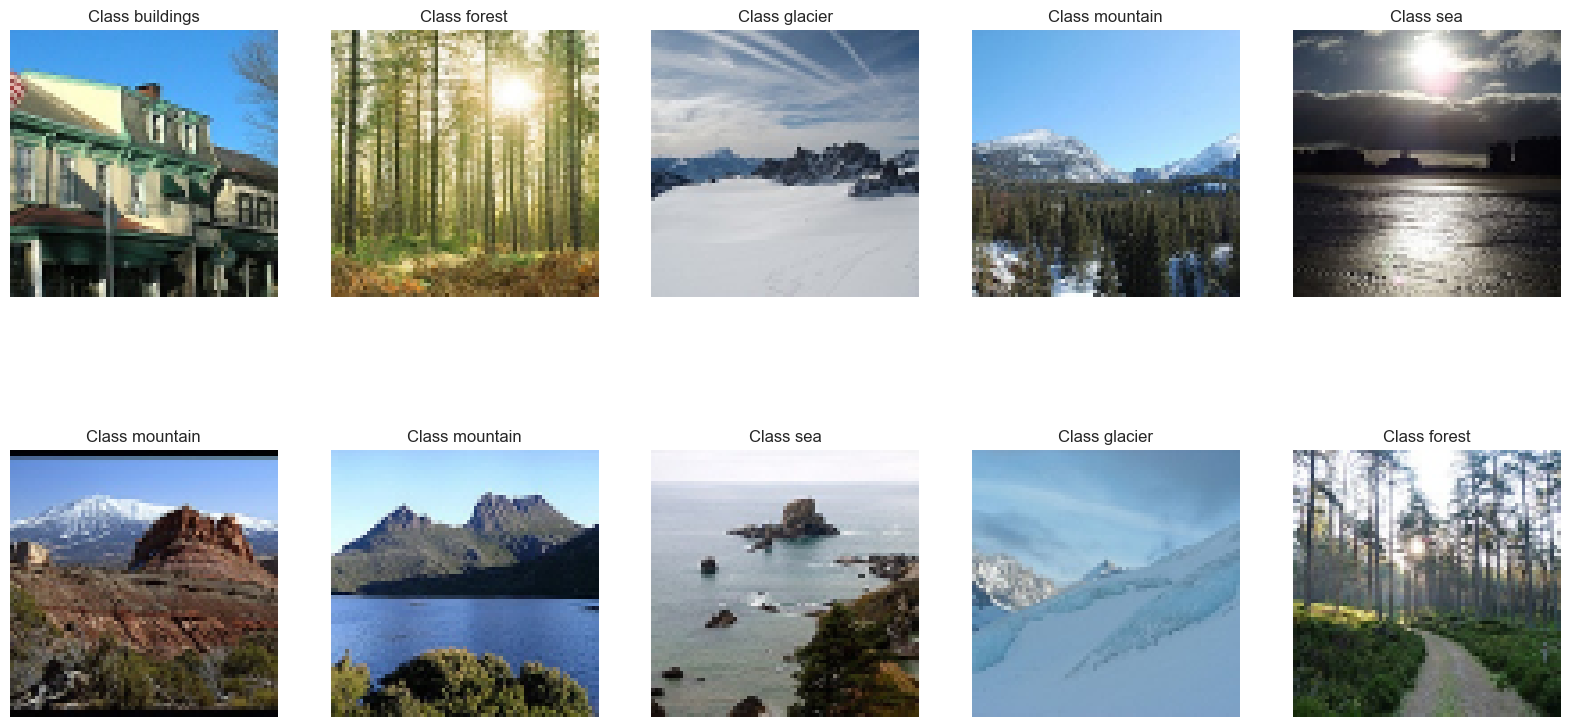

In [164]:
#visualize resized images of lower quality
visualise_images(train_data, train_labels)

# Classical approach

I will use color histograms and HOGs as features.

In [ ]:
def calc_color_hist(img):
    '''
    calculates color histogram of an image using HSV format
    '''
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([img], [0], None, [16], [0, 180])
    return hist

In [ ]:
def calc_hog(img):
    '''
    calculate hostogram of oriented gradients (hog)
    '''
    hog = cv2.HOGDescriptor()
    #first resize image to get the same number of values
    img = cv2.resize(img, (64, 128), interpolation = cv2.INTER_AREA)
    h = hog.compute(img)
    return h

### Prepare train set

In [ ]:
### Using color histograms and HOGs

In [ ]:
#use one data for train and validation. futher will use in cross-validation
train_data = np.vstack([train_data, val_data])

In [ ]:
train_df = list(map(lambda x: calc_color_hist(x) + hog(x), train_data))
test_df = list(map(lambda x: calc_color_hist(x) + hog(x), test_df))

In [13]:
train_df = list(map(lambda x: x.flatten(), train_data))

In [14]:
train_df = pd.DataFrame(train_df)

In [15]:
train_df = train_df.astype("float")
train_df = train_df.fillna(0)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14034 entries, 0 to 14033
Columns: 2700 entries, 0 to 2699
dtypes: float64(2700)
memory usage: 289.1 MB


In [17]:
train_df.isna().sum().sum()

0

### Prepare test set

In [18]:
test_df = list(map(lambda x: x.flatten(), test_data))

In [19]:
test_df = pd.DataFrame(test_df)

In [20]:
test_df=test_df.astype("float")
test_df=test_df.fillna(0)

### Prepare holdout set

In [21]:
holdout_df = list(map(lambda x: x.flatten(), holdout_data))

In [22]:
holdout_df = pd.DataFrame(holdout_df)
holdout_df = holdout_df.astype("float")
holdout_df = holdout_df.fillna(0)

## Logistic regression

### Base model

In [21]:
#base model
lr = LogisticRegression(random_state=42)

In [22]:
lr.fit(train_df, train_labels)

LogisticRegression(random_state=42)

In [23]:
y_pred = lr.predict(test_df)
y_probs = lr.predict_proba(test_df)

In [24]:
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.5380


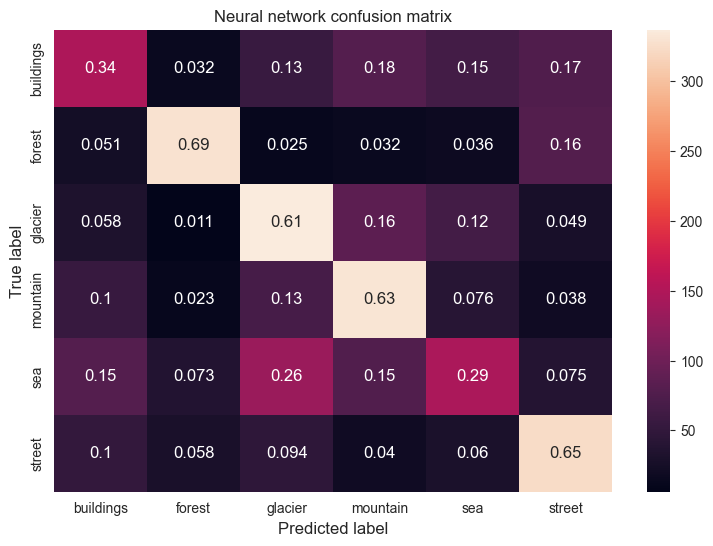

In [25]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [26]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.38      0.34      0.36       437
      forest       0.77      0.69      0.73       474
     glacier       0.52      0.61      0.56       553
    mountain       0.55      0.63      0.58       525
         sea       0.40      0.29      0.33       510
      street       0.58      0.65      0.61       501

    accuracy                           0.54      3000
   macro avg       0.53      0.53      0.53      3000
weighted avg       0.53      0.54      0.53      3000



### Try PSA

In [27]:
pca = PCA(n_components=0.95)

In [28]:
train_df_pca = pca.fit_transform(train_df)
test_df_pca = pca.transform(test_df)

In [29]:
train_df_pca.shape

(14034, 267)

In [30]:
lr.fit(train_df_pca, train_labels)

LogisticRegression(random_state=42)

In [31]:
y_pred = lr.predict(test_df_pca)
y_probs = lr.predict_proba(test_df_pca)

In [32]:
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.5320


After pca accurace got lower. I will leave previous features.

### Huperparameters tunning

with the whole train dataset

In [34]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [35]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {'penalty': ['l2', 'l1', 'elasticnet', None],
          'C': [0.1, 1, 10, 100]}


grid = GridSearchCV(estimator=lr, param_grid=params, cv=cv, scoring='accuracy', verbose=2)

grid.fit(train_df, train_labels)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................................C=0.1, penalty=l2; total time=   8.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   8.2s
[CV] END ..................................C=0.1, penalty=l2; total time=   8.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   7.7s
[CV] END ..................................C=0.1, penalty=l2; total time=   7.6s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..........................C=0.1, penalty=elasticnet; total time=   0.0s
[CV] END ..........................C=0.1, penalt

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100],
                         'penalty': ['l2', 'l1', 'elasticnet', None]},
             scoring='accuracy', verbose=2)

In [36]:
grid.best_params_

{'C': 0.1, 'penalty': None}

In [24]:
lr = LogisticRegression(C=1, penalty='l2')

In [26]:
# lr = grid.best_estimator_
lr.fit(train_df, train_labels)

LogisticRegression(C=1)

LogisticRegression(C=1)

In [28]:
y_pred = lr.predict(test_df)
y_probs = lr.predict_proba(test_df)

In [29]:
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.5380


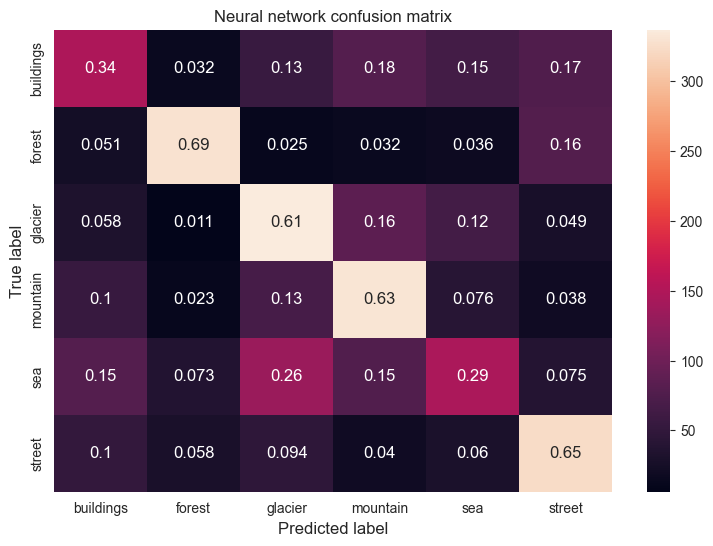

In [30]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

We can see that buildings and sea are the most difficult to predict

In [31]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.38      0.34      0.36       437
      forest       0.77      0.69      0.73       474
     glacier       0.52      0.61      0.56       553
    mountain       0.55      0.63      0.58       525
         sea       0.40      0.29      0.33       510
      street       0.58      0.65      0.61       501

    accuracy                           0.54      3000
   macro avg       0.53      0.53      0.53      3000
weighted avg       0.53      0.54      0.53      3000



### Check on holdout set

In [56]:
y_pred = lr.predict(holdout_df)
y_probs = lr.predict_proba(holdout_df)

In [57]:
print(f"Accuracy: {accuracy_score(holdout_labels, y_pred): .4f}")

Accuracy:  0.5254


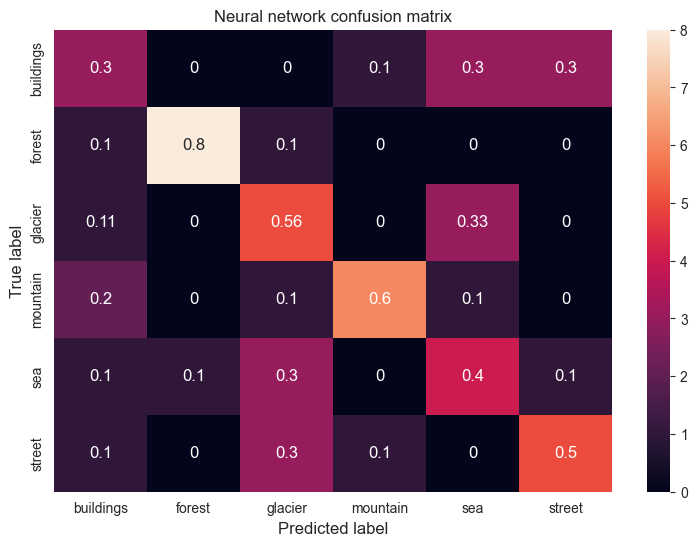

In [58]:
conf = confusion_matrix(holdout_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

We can see from here that **forest** and **mountain** are the best recognized by Logistic Regression model.

In [59]:
print(classification_report(holdout_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.33      0.30      0.32        10
      forest       0.89      0.80      0.84        10
     glacier       0.38      0.56      0.45         9
    mountain       0.75      0.60      0.67        10
         sea       0.36      0.40      0.38        10
      street       0.56      0.50      0.53        10

    accuracy                           0.53        59
   macro avg       0.55      0.53      0.53        59
weighted avg       0.55      0.53      0.53        59



### Save accuracy to scores dictionary

In [60]:
scores = {}
scores['LinearRegression']=accuracy_score(holdout_labels, y_pred)

In [63]:
auc_scores = calculate_auc_scores(holdout_labels, y_probs, ind2class.keys())

### Roc-Auc curves

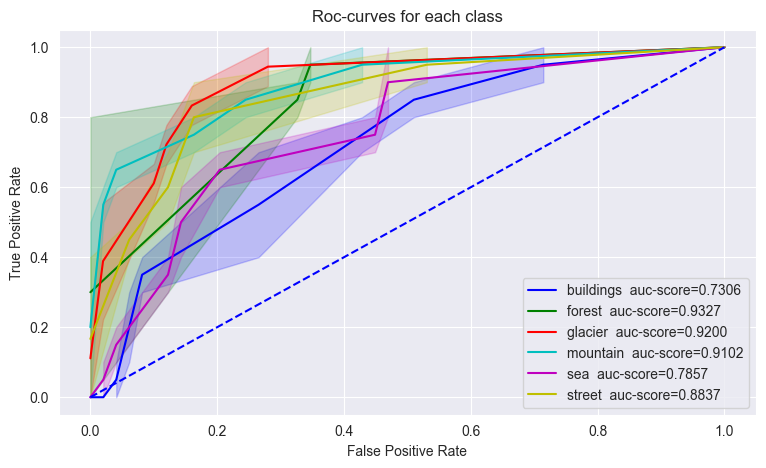

In [67]:
plot_roc_curves_ovr(holdout_df, holdout_labels, y_probs, list(class2ind.keys()), auc_scores)

### Precision-recall curves

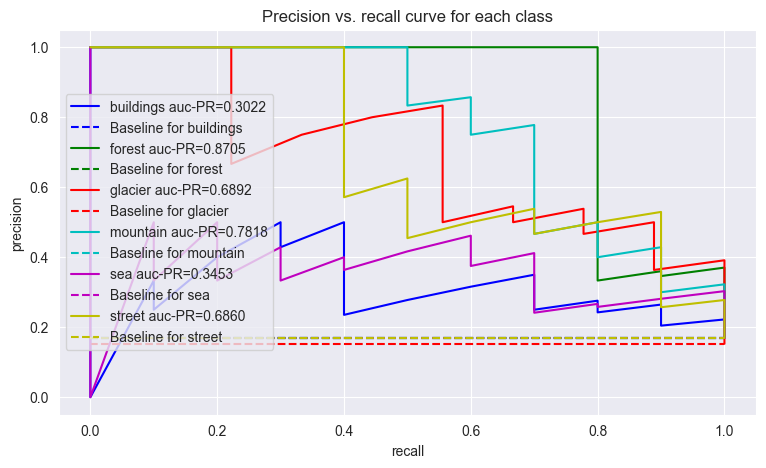

In [68]:
plot_precision_recall_curves(holdout_labels, y_probs, list(class2ind.keys()))

In general we see low prediction results. Only **forest** and **mountain** were predicted confidently.

## KNN

### Base model

In [50]:
knn = KNeighborsClassifier(n_neighbors=5)

In [51]:
knn.fit(train_df, train_labels)

KNeighborsClassifier()

In [52]:
y_pred = knn.predict(test_df)
y_probs = knn.predict_proba(test_df)
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.4807


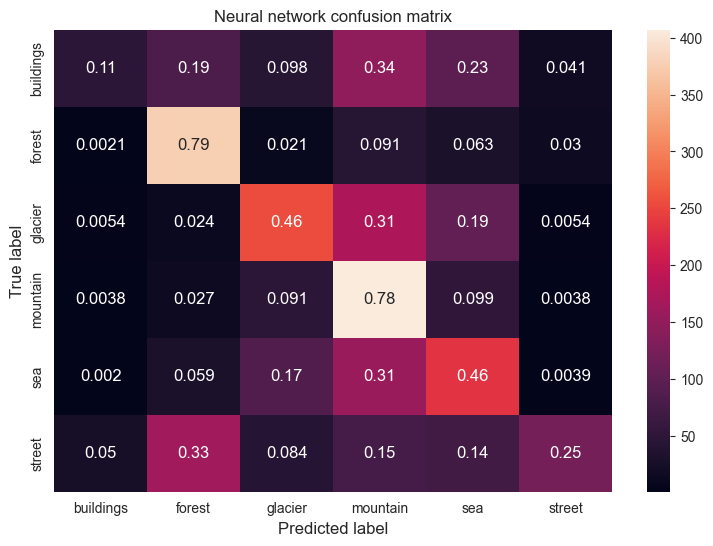

In [53]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [54]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.59      0.11      0.18       437
      forest       0.55      0.79      0.65       474
     glacier       0.53      0.46      0.49       553
    mountain       0.40      0.78      0.53       525
         sea       0.39      0.46      0.42       510
      street       0.76      0.25      0.37       501

    accuracy                           0.48      3000
   macro avg       0.54      0.47      0.44      3000
weighted avg       0.54      0.48      0.45      3000



### Hyperparameters tunning

In [55]:
knn = KNeighborsClassifier()

In [56]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
        'n_neighbors': [3, 5, 7, 9, 11],
         'metric': ['euclidian', 'cosine', 'cityblock']
}

grid = GridSearchCV(estimator=knn, param_grid=params, cv=cv, scoring='accuracy', verbose=2)

grid.fit(train_df, train_labels)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ....................metric=euclidian, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=5; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=5; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=5; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=5; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=5; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=7; total time=   0.0s
[CV] END ....................metric=euclidian, n

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidian', 'cosine', 'cityblock'],
                         'n_neighbors': [3, 5, 7, 9, 11]},
             scoring='accuracy', verbose=2)

In [57]:
grid.best_params_

{'metric': 'cityblock', 'n_neighbors': 9}

In [69]:
# knn = grid.best_estimator_
knn=KNeighborsClassifier(metric='cityblock', n_neighbors= 9)
knn.fit(train_df, train_labels)

KNeighborsClassifier(metric='cityblock', n_neighbors=9)

In [41]:
y_pred = knn.predict(test_df)
y_probs = knn.predict_proba(test_df)

In [42]:
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.5060


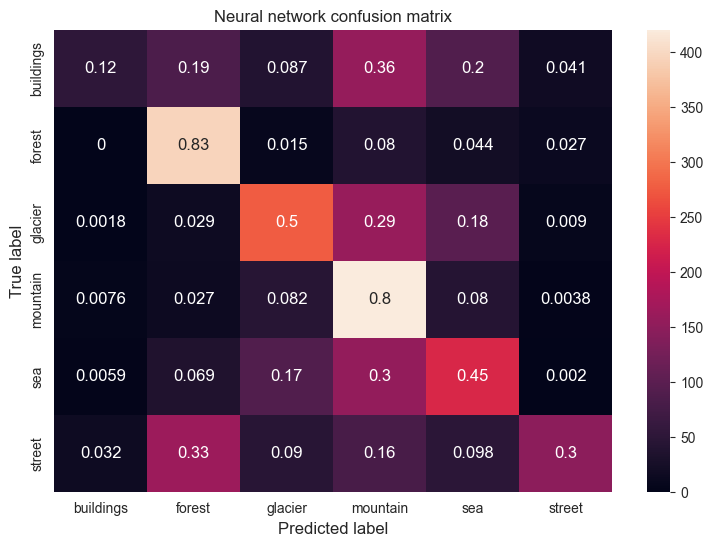

In [43]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [44]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.68      0.12      0.20       437
      forest       0.56      0.83      0.67       474
     glacier       0.55      0.50      0.53       553
    mountain       0.42      0.80      0.55       525
         sea       0.43      0.45      0.44       510
      street       0.79      0.30      0.43       501

    accuracy                           0.51      3000
   macro avg       0.57      0.50      0.47      3000
weighted avg       0.57      0.51      0.47      3000



### Check on holdout set

In [70]:
y_pred = knn.predict(holdout_df)
y_probs = knn.predict_proba(holdout_df)
print(f"Accuracy: {accuracy_score(holdout_labels, y_pred): .4f}")

Accuracy:  0.4746


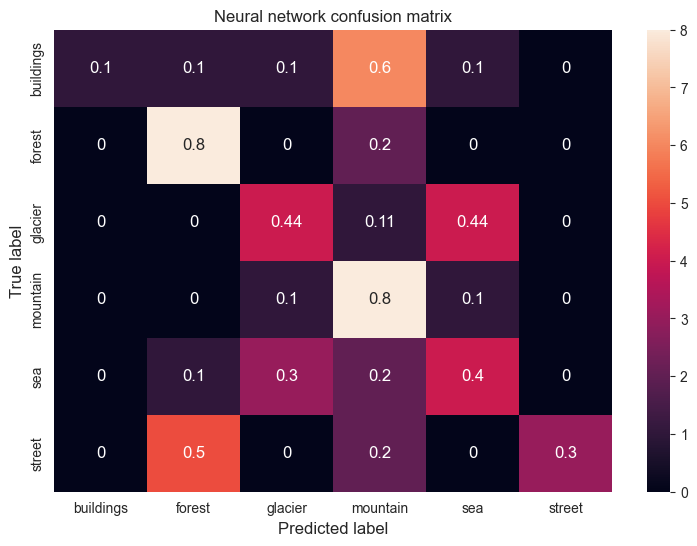

In [48]:
conf = confusion_matrix(holdout_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

Here we can see that KNN managed to predict good **forest** and **mountain**, but the rest classes are very poor.

In [49]:
print(classification_report(holdout_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       1.00      0.10      0.18        10
      forest       0.53      0.80      0.64        10
     glacier       0.44      0.44      0.44         9
    mountain       0.38      0.80      0.52        10
         sea       0.40      0.40      0.40        10
      street       1.00      0.30      0.46        10

    accuracy                           0.47        59
   macro avg       0.63      0.47      0.44        59
weighted avg       0.63      0.47      0.44        59



In [71]:
scores['Knn']=accuracy_score(holdout_labels, y_pred)

### Roc-Auc scores

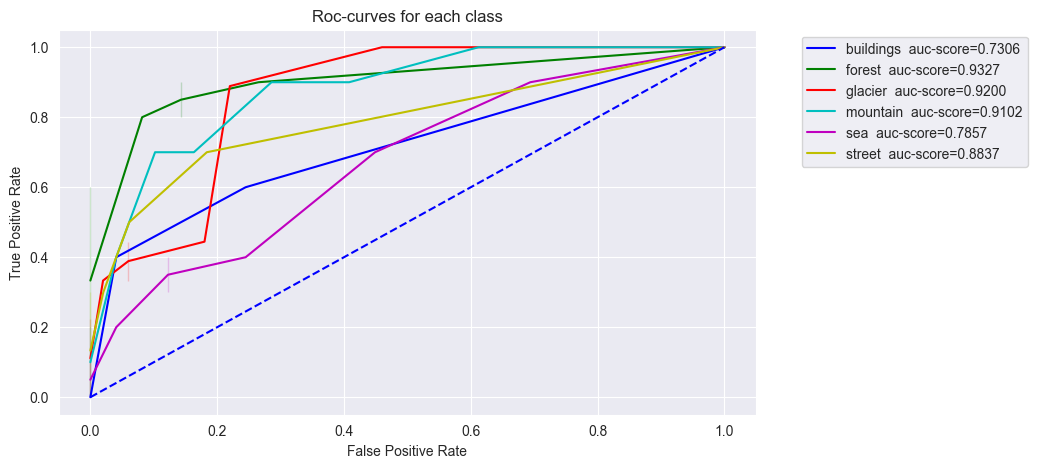

In [103]:
plot_roc_curves_ovr(holdout_df, holdout_labels, y_probs, list(class2ind.keys()), auc_scores)

### Precision-recall curves

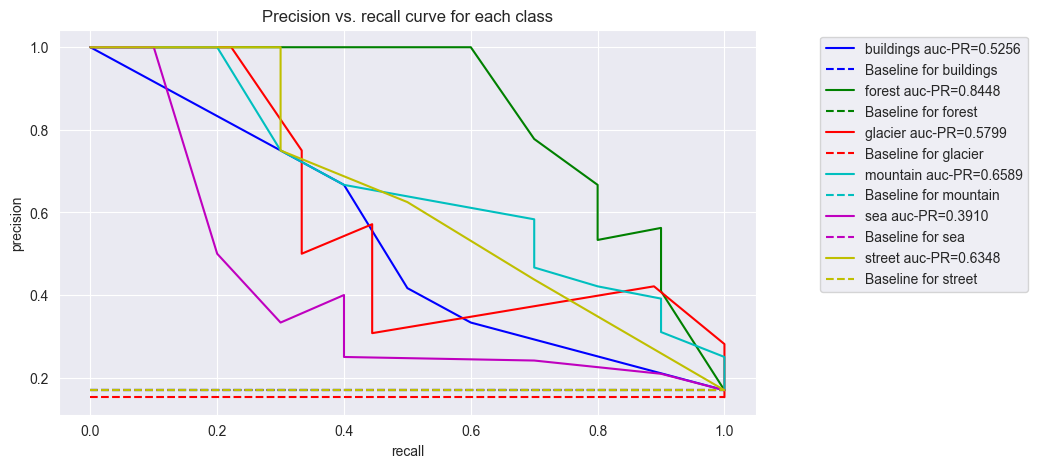

In [104]:
plot_precision_recall_curves(holdout_labels, y_probs, list(class2ind.keys()))

## SVM

### Base model

In [71]:
svc = SVC(kernel='rbf', random_state=42, probability=True)

In [72]:
svc.fit(train_df, train_labels)

SVC(probability=True, random_state=42)

In [73]:
y_pred = svc.predict(test_df)
y_probs = svc.predict_proba(test_df)
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.6470


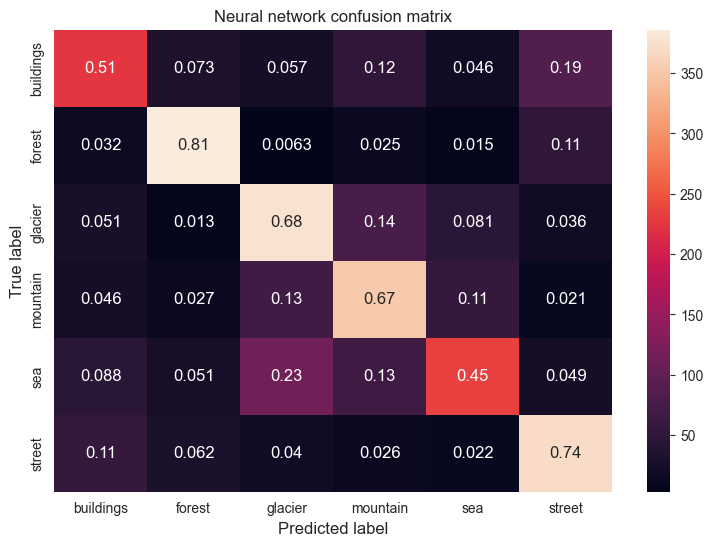

In [74]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

Here **sea** and **buildings** got the lowest score for prediction.

In [75]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.57      0.51      0.54       437
      forest       0.78      0.81      0.80       474
     glacier       0.62      0.68      0.65       553
    mountain       0.62      0.67      0.64       525
         sea       0.63      0.45      0.53       510
      street       0.66      0.74      0.70       501

    accuracy                           0.65      3000
   macro avg       0.65      0.65      0.64      3000
weighted avg       0.64      0.65      0.64      3000



### Hyperparameters tunning

In [77]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

params = {
        'C': [1, 100],
         'gamma': [0.01, 1, 10]
}

grid = GridSearchCV(estimator=svc, param_grid=params, cv=cv, scoring='accuracy', verbose=2)

grid.fit(train_df, train_labels)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ....................................C=1, gamma=0.01; total time=19.4min
[CV] END ....................................C=1, gamma=0.01; total time=19.4min
[CV] END ....................................C=1, gamma=0.01; total time=19.5min
[CV] END .......................................C=1, gamma=1; total time=19.4min
[CV] END .......................................C=1, gamma=1; total time=19.4min
[CV] END .......................................C=1, gamma=1; total time=19.4min
[CV] END ......................................C=1, gamma=10; total time=19.5min
[CV] END ......................................C=1, gamma=10; total time=19.4min
[CV] END ......................................C=1, gamma=10; total time=19.5min
[CV] END ..................................C=100, gamma=0.01; total time=19.4min
[CV] END ..................................C=100, gamma=0.01; total time=19.4min
[CV] END ..................................C=100,

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [1, 100], 'gamma': [0.01, 1, 10]},
             scoring='accuracy', verbose=2)

In [78]:
grid.best_params_

{'C': 1, 'gamma': 0.01}

In [105]:
#svc = grid.best_estimator_
svc = SVC(kernel='rbf', C=1, gamma=0.01, random_state=42, probability=True)
svc.fit(train_df, train_labels)

SVC(C=1, gamma=0.01, probability=True, random_state=42)

In [106]:
y_pred = svc.predict(test_df)
y_probs = svc.predict_proba(test_df)
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.1750


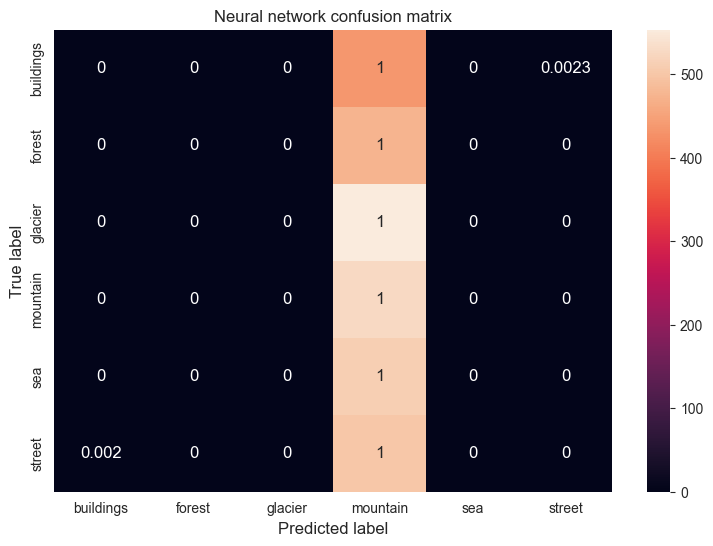

In [107]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [ ]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

### Check on holdout set

In [ ]:
y_pred = svc.predict(holdout_df)
y_probs = svc.predict_proba(holdout_df)
print(f"Accuracy: {accuracy_score(holdout_labels, y_pred): .4f}")

In [ ]:
conf = confusion_matrix(holdout_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [ ]:
print(classification_report(holdout_labels, y_pred, target_names=class2ind.keys()))

In [ ]:
scores['SVC']=accuracy_score(holdout_labels, y_pred)

In [ ]:
### Roc-Auc scores

In [ ]:
plot_roc_curves_ovr(holdout_df, holdout_labels, y_probs, list(class2ind.keys()), auc_scores)

In [ ]:
### Precision-recall curves

In [ ]:
plot_precision_recall_curves(holdout_labels, y_probs, list(class2ind.keys()))

For classical features I will use histograms as bag of visual words.
I will create normalized histogram of the whole image, and of its parts:
* dividing the image into 9 subblocks: 50X50 pixels each
* dividing the image into 3 horizontal blocks: 50X150 pixels each
* dividing the image into 3 vertical blocks: 150X50 pixels each
and computing histograms of all of them.

I will use 16 bins. And as it will be done for 3 channels, I will get 3*(3+3+9)*16=720 features.

In [211]:
def calc_hist(img):
    '''
    Simple histogram of 16 bins for each channels
    :return: concatenated histogram of three channels, array of shape (48,1)
    '''
    r_hist = cv2.calcHist(img, [0], None, [16], [0, 256])
    g_hist = cv2.calcHist(img, [1], None, [16], [0, 256])
    b_hist = cv2.calcHist(img, [2], None, [16], [0, 256])


    #normalize histograms
    cv2.normalize(r_hist, r_hist, 0, 1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(g_hist, g_hist, 0, 1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(b_hist, b_hist, 0, 1, norm_type=cv2.NORM_MINMAX)

    #calculate histograms of 9 subblocks of 50X50 length
    # r_subblocks=[]
    # g_subblocks=[]
    # b_subblocks=[]
    # for i in range(3):
    #     for j in range(3):
    #         r_subblocks.append(cv2.calcHist(img[i*50:(i+1)*50, j*50:(j+1)*50], [0], None, [16], [0, 256]))
    #         g_subblocks.append(cv2.calcHist(img[i*50:(i+1)*50, j*50:(j+1)*50], [1], None, [16], [0, 256]))
    #         b_subblocks.append(cv2.calcHist(img[i*50:(i+1)*50, j*50:(j+1)*50], [2], None, [16], [0, 256]))
    #
    # print(len(r_subblocks))
    # print(r_subblocks)
    # #calculate histograms of horizontal blocks (50X150)
    # r_hor = []
    # g_hor = []
    # b_hor = []
    # for i in range(3):
    #     r_hor.append(cv2.calcHist(img[i*50:(i+1)*50, :], [0], None, [16], [0, 256]))
    #     g_hor.append(cv2.calcHist(img[i*50:(i+1)*50,:], [1], None, [16], [0, 256]))
    #     b_hor.append(cv2.calcHist(img[i*50:(i+1)*50, :], [2], None, [16], [0, 256]))
    #
    # #calculate histograms of vertical blocks (50X150)
    # r_vert = []
    # g_vert = []
    # b_vert = []
    # for i in range(3):
    #     r_vert.append(cv2.calcHist(img[:, i*50:(i+1)*50], [0], None, [16], [0, 256]))
    #     g_vert.append(cv2.calcHist(img[:, i*50:(i+1)*50], [1], None, [16], [0, 256]))
    #     b_vert.append(cv2.calcHist(img[:, i*50:(i+1)*50], [2], None, [16], [0, 256]))

    result = np.array(np.vstack([r_hist, g_hist, b_hist])).flatten()


    return result

    # return np.vstack([np.array(r_hist).flatten(),
    #                   np.array(g_hist).flatten(),
    #                   np.array(b_hist).flatten(),
    #                   np.array(r_subblocks).flatten(),
    #                   np.array(g_subblocks).flatten(),
    #                   np.array(b_subblocks).flatten(),
    #                   np.array(r_hor).flatten(),
    #                   np.array(g_hor).flatten(),
    #                   np.array(b_hor).flatten(),
    #                   np.array(r_vert).flatten(),
    #                   np.array(g_vert).flatten(),
    #                   np.array(b_vert).flatten()])

In [212]:
rgb_hist = calc_hist(train_data[1])

In [213]:
print(rgb_hist)

[0.         0.         0.         0.         0.4473684  0.2236842
 0.36842105 0.67105263 0.7236842  0.43421054 0.32894737 1.
 0.7236842  0.36842105 0.6184211  0.01315789 0.         0.
 0.         0.         0.42857143 0.20238096 0.3809524  0.6547619
 0.5595238  0.3452381  0.2857143  1.         0.5833334  0.29761904
 0.47619048 0.14285715 0.         0.         0.         0.
 0.5285714  0.17142858 0.42857143 0.85714287 0.6142857  0.51428574
 0.31428573 0.94285715 1.         0.2857143  0.31428573 0.45714286]


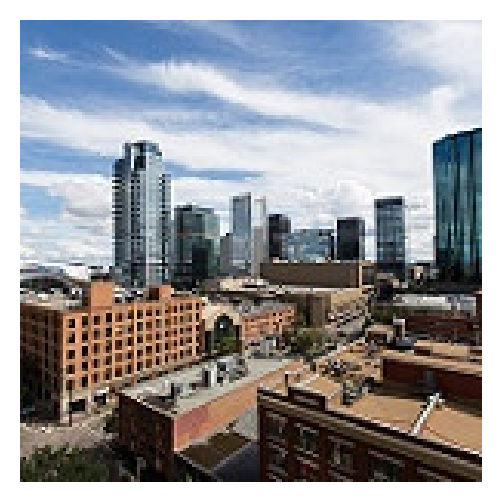

In [214]:
plt.figure(figsize=(5,3))
plt.imshow(train_data[1])
plt.axis("off")
plt.show()

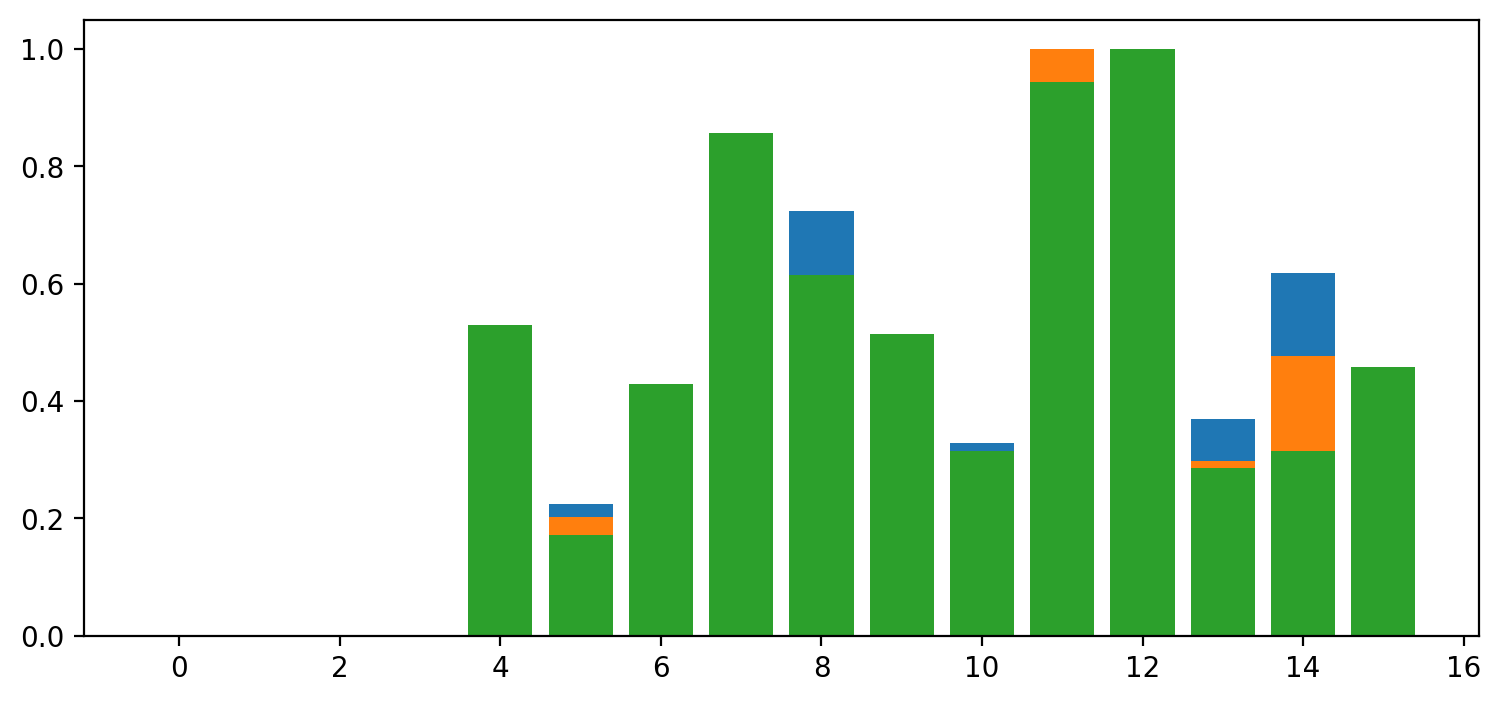

In [215]:
plt.figure(figsize=(9,4))
plt.bar(x=range(16), height = rgb_hist[:16].ravel())
plt.bar(x=range(16), height = rgb_hist[16:32].ravel())
plt.bar(x=range(16), height = rgb_hist[32:48].ravel())
plt.show()

In [216]:
train_hist = []
for image in train_data:
    train_hist.append(calc_hist(image))

In [217]:
test_hist = []
for image in test_data:
    test_hist.append(calc_hist(image))

In [218]:
X_train = pd.DataFrame(train_hist)
X_test = pd.DataFrame(test_hist)
y_train = pd.Series(train_labels)
y_test = pd.Series(test_labels)

In [219]:
X_train

0             1         2         3         4         5   \
0      0.000000  0.000000e+00  0.000000  0.000000  0.000000  0.000000   
1      0.000000  0.000000e+00  0.000000  0.000000  0.447368  0.223684   
2      0.000000  0.000000e+00  0.000000  0.010309  0.000000  0.020619   
3      0.775862  1.000000e+00  0.379310  0.224138  0.206897  0.224138   
4      0.881890  2.992126e-01  0.244094  1.000000  0.181102  0.811024   
...         ...           ...       ...       ...       ...       ...   
14029  0.420290  1.014493e-01  0.072464  0.202899  0.144928  0.115942   
14030  0.185897  1.000000e+00  0.384615  0.179487  0.217949  0.275641   
14031  0.279412  4.411765e-01  0.110294  0.110294  0.117647  0.110294   
14032  1.000000  9.470199e-01  0.039735  0.000000  0.006623  0.112583   
14033  0.216216 -7.450581e-09  0.135135  0.270270  0.351351  0.837838   

             6         7             8         9   ...        38        39  \
0      0.000000  0.000000  0.000000e+00  0.000000  ...  0.000000  0.000000   
1      0.368421  0.671053  7.236842e-01  0.434211  ...  0.428571  0.857143   
2      0.010309  0.072165  6.701031e-01  0.515464  ...  0.032609  0.097826   
3      0.396552  0.586207  4.827586e-01  0.586207  ...  0.543860  0.631579   
4      0.125984  0.000000  0.000000e+00  0.000000  ...  0.153846  0.000000   
...         ...       ...           ...       ...  ...       ...       ...   
14029  0.057971  0.000000  1.449275e-02  0.000000  ...  0.095238  0.023810   
14030  0.121795  0.025641 -4.656613e-10  0.019231  ...  0.191489  0.085106   
14031  0.088235  0.110294  8.088236e-02  0.066176  ...  0.156250  0.148438   
14032  0.827815  0.046358  0.000000e+00  0.000000  ...  0.000000  0.000000   
14033  1.000000  0.621622  9.189189e-01  0.783784  ...  1.000000  0.756757   

             40        41            42        43        44        45  \
0      0.000000  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
1      0.614286  0.514286  3.142857e-01  0.942857  1.000000  0.285714   
2      0.728261  0.608696  1.847826e-01  0.184783  0.847826  0.619565   
3      0.526316  0.491228  2.456140e-01  0.719298  1.000000  0.631579   
4      0.000000  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
...         ...       ...           ...       ...       ...       ...   
14029  0.047619  0.023810 -9.313226e-10  0.047619  0.047619  0.119048   
14030  0.035461  0.042553  3.546099e-02  0.042553  0.063830  0.028369   
14031  0.125000  0.085938  7.031250e-02  0.125000  0.023438  0.000000   
14032  0.000000  0.161538  6.230769e-01  0.369231  0.000000  0.000000   
14033  0.567568  0.243243  4.324324e-01  0.324324  0.162162  0.162162   

             46        47  
0      0.000000  1.000000  
1      0.314286  0.457143  
2      1.000000  0.467391  
3      0.070175  0.000000  
4      0.000000  0.000000  
...         ...       ...  
14029  0.071429  1.000000  
14030  0.049645  0.000000  
14031  0.093750  1.000000  
14032  0.000000  0.000000  
14033  0.648649  0.513514  

[14034 rows x 48 columns]

In [220]:
X_test

0         1         2         3         4         5         6   \
0     0.000000  0.000000  0.000000  0.036585  0.048780  0.097561  0.524390   
1     0.017857  0.044643  0.089286  0.151786  0.187500  0.133929  0.946429   
2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3     0.010638  0.074468  0.000000  0.074468  0.095745  0.085106  0.085106   
4     0.000000  0.000000  1.000000  0.000000  0.033333  0.966667  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
2995  0.000000  0.000000  0.024631  0.078818  0.167488  0.157635  0.108374   
2996  0.046931  0.018051  0.018051  0.054152  0.061372  0.104693  0.115523   
2997  1.000000  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
2998  0.000000  0.000000  0.000000  0.000000  0.000000  0.012552  0.008368   
2999  0.909722  1.000000  0.666667  0.361111  0.083333  0.020833  0.020833   

            7         8         9   ...        38        39        40  \
0     0.439024  0.634146  0.707317  ...  0.628205  0.384615  0.769231   
1     0.187500  0.062500  0.053571  ...  0.820513  0.188034  0.051282   
2     0.000000  0.000000  0.000000  ...  0.016129  0.000000  0.010753   
3     0.085106  0.159574  0.680851  ...  0.079545  0.125000  0.215909   
4     0.000000  0.106667  0.893333  ...  0.000000  0.000000  0.013333   
...        ...       ...       ...  ...       ...       ...       ...   
2995  0.152709  0.137931  0.147783  ...  0.193548  0.112903  0.188172   
2996  0.079422  0.028881  0.046931  ...  0.072581  0.092742  0.032258   
2997  0.000000  0.000000  0.086667  ...  0.000000  0.000000  0.000000   
2998  0.025105  0.179916  0.104603  ...  0.012712  0.000000  0.148305   
2999  0.041667  0.013889  0.000000  ...  0.020000  0.026667  0.026667   

            41        42        43        44        45        46        47  
0     0.641026  0.217949  0.205128  0.461538  0.269231  1.000000  0.756410  
1     0.094017  0.102564  1.000000  0.076923  0.692308  0.341880  0.000000  
2     0.005376  0.000000  0.000000  0.043011  0.639785  1.000000  0.672043  
3     0.727273  0.704545  1.000000  0.363636  0.079545  0.318182  0.931818  
4     0.986667  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
...        ...       ...       ...       ...       ...       ...       ...  
2995  0.193548  0.086022  0.086022  0.059140  0.016129  0.032258  1.000000  
2996  0.048387  0.032258  0.000000  0.032258  0.016129  0.000000  1.000000  
2997  0.040000  0.593333  0.366667  0.000000  0.000000  0.000000  0.000000  
2998  0.059322  0.262712  1.000000  0.411017  0.000000  0.000000  0.000000  
2999  0.020000  0.006667  0.006667  0.000000  0.000000  0.000000  0.000000  

[3000 rows x 48 columns]

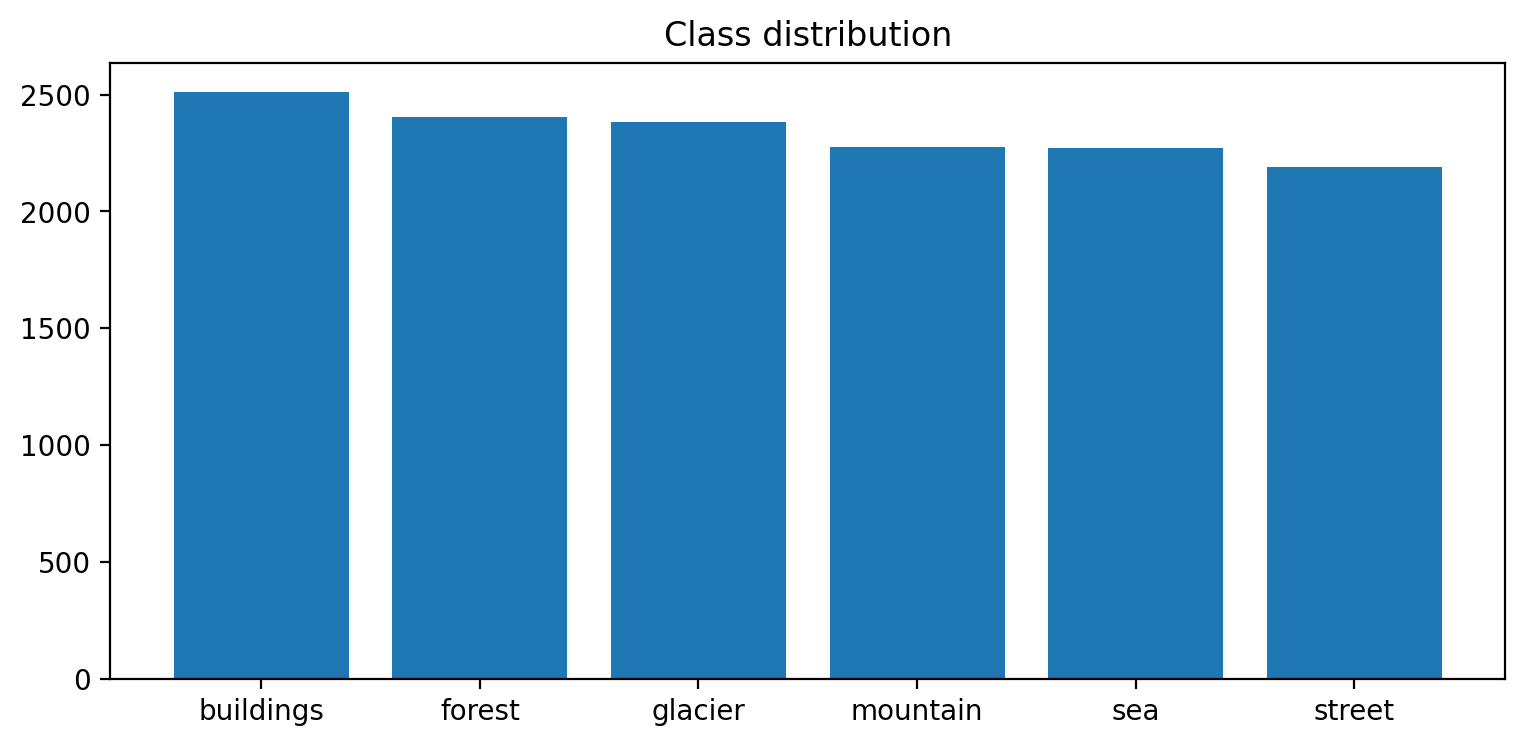

In [221]:
plt.figure(figsize=(9,4))
plt.bar(x=range(1,7), height=y_train.value_counts())
plt.xticks(range(1,7), ind2class.values())
plt.title("Class distribution")
plt.show()

In [222]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 42, stratify=train_labels)

In [223]:
X_train.shape

(11227, 48)

In [224]:
X_val.shape

(2807, 48)

In [225]:
X_test.shape

(3000, 48)

## Logistic regression model

In [206]:
lr = LogisticRegression()

In [207]:
lr.fit(X_train, y_train)

LogisticRegression()

In [208]:
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)

In [209]:
y_pred

array([3, 3, 3, ..., 4, 3, 1], dtype=int64)

In [210]:
print(f"Accuracy {accuracy_score(y_test, y_pred): .4f}")

Accuracy  0.3097


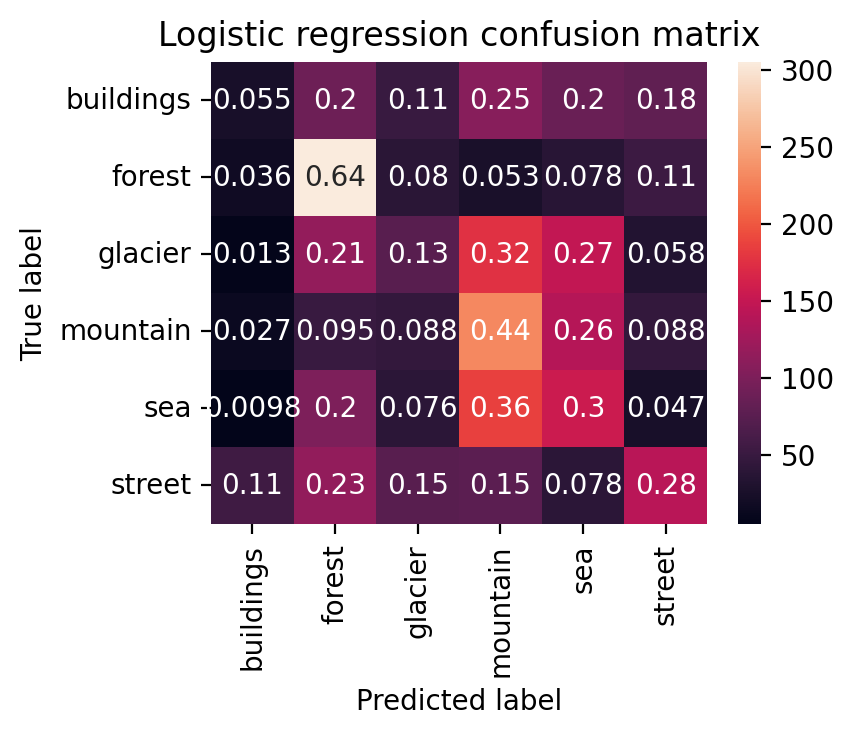

In [227]:
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3));
sns.heatmap(conf,
            annot=conf/conf.astype(np.float).sum(axis=1, keepdims=True), #normalized by true class sizes
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys());
plt.title('Logistic regression confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

In [228]:
print(classification_report(y_test, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.20      0.05      0.09       437
      forest       0.39      0.64      0.49       474
     glacier       0.23      0.13      0.17       553
    mountain       0.29      0.44      0.35       525
         sea       0.26      0.30      0.28       510
      street       0.38      0.28      0.32       501

    accuracy                           0.31      3000
   macro avg       0.29      0.31      0.28      3000
weighted avg       0.29      0.31      0.28      3000



<AxesSubplot: >

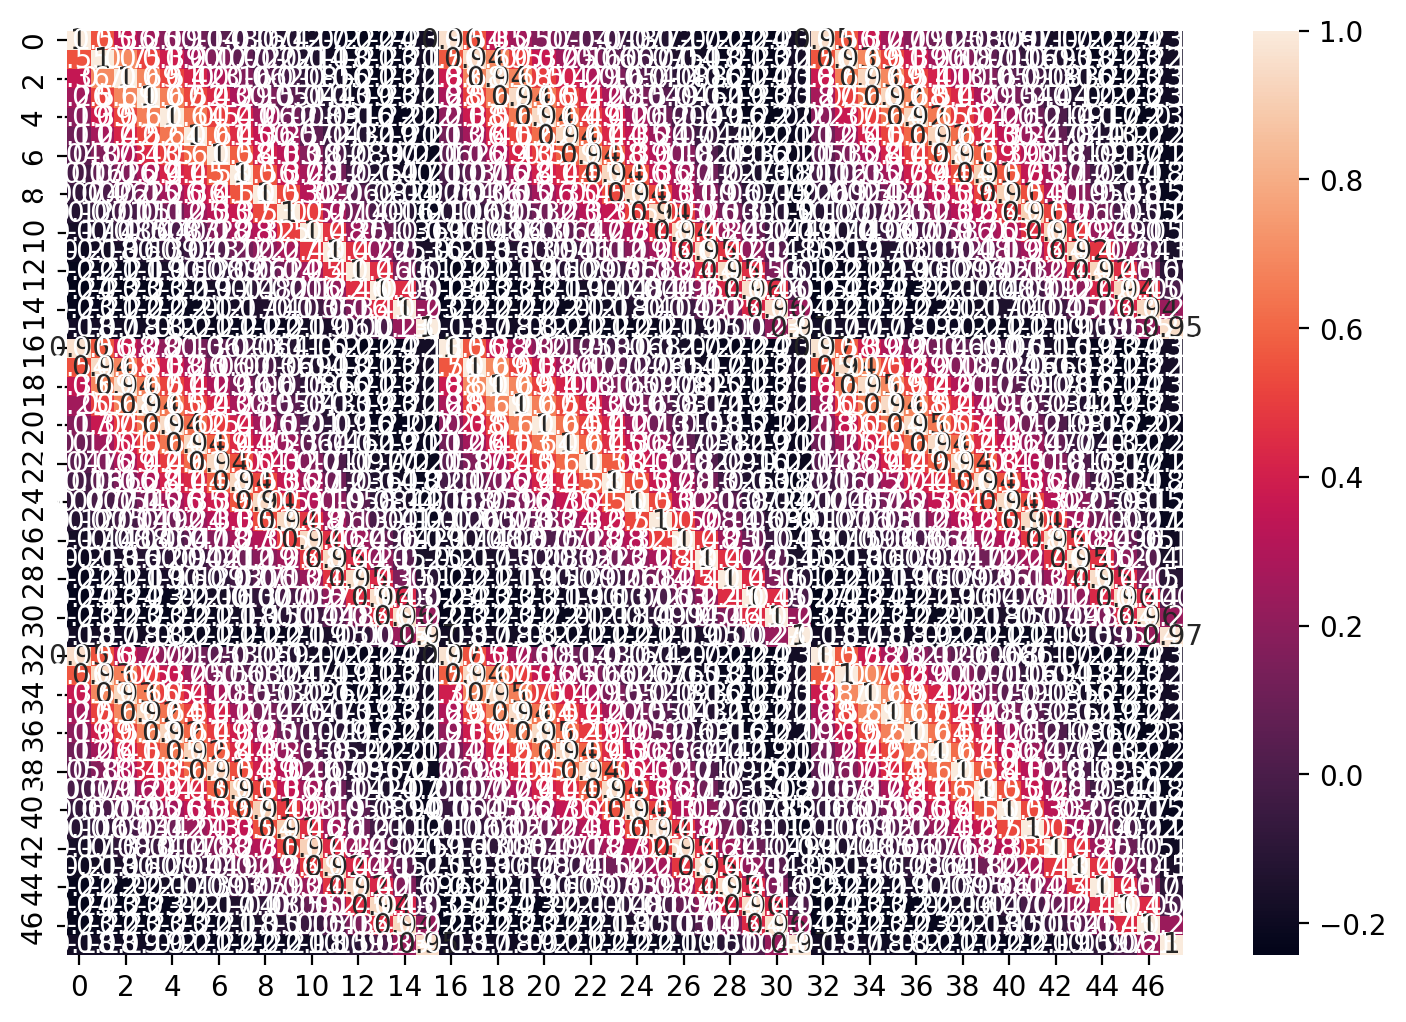

In [230]:
corr = X_train.corr()
sns.heatmap(corr, annot=True)

Features are highly correlated. Let's do PCA.

In [233]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)

In [235]:
X_train_pca.shape

(11227, 15)

In [238]:
X_test_pca = pca.transform(X_test)

### Tuning hyperparameters

In [240]:
lr.fit(X_train_pca, y_train)

LogisticRegression()

In [241]:
y_pred = lr.predict(X_test_pca)
y_prob = lr.predict_proba(X_test_pca)

In [242]:
print(f"Accuracy {accuracy_score(y_test, y_pred): .4f}")

Accuracy  0.3470


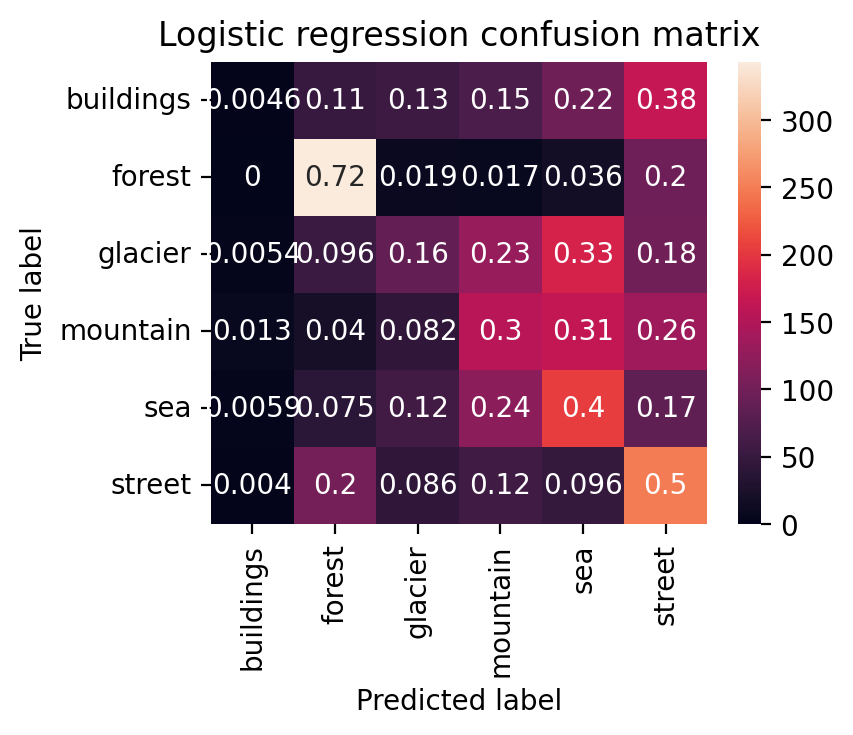

In [243]:
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3));
sns.heatmap(conf,
            annot=conf/conf.astype(np.float).sum(axis=1, keepdims=True), #normalized by true class sizes
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys());
plt.title('Logistic regression confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

### Using keypoints and descriptors

In [258]:
def get_keypoints(img, maxFeatures):
    # convert input image to grayscale
   imageGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # use ORB to detect keypoints and extract (binary) local
	# invariant features
   orb = cv2.ORB_create(maxFeatures)
	# extract keypoints and descriptors for image A
   (kps, descs) = orb.detectAndCompute(imageGray, None)
   if (kps is not None) and (descs is not None):
        output_image = cv2.drawKeypoints(img, kps, 0, (0, 0, 255),
                                 flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
        cv2.imshow("Keypoints", output_image)
        cv2.waitKey(0)

   return kps, descs


In [260]:
kps, descs = get_keypoints(train_data[0], 100)

In [262]:
len(descs)

56

# NN approach

### Create dataset of image folders

In [165]:
#make seed for the same randomness
torch.manual_seed(42)

In [166]:
train_path = "Classification_data/train/"
test_path = "Classification_data/test/"
val_path = "Classification_data/validation/"

In [167]:
train_transform = transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.RandomRotation((0,40)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop((150, 150), scale=(0.2, 1), ratio=(1, 1)),
    transforms.ToTensor(), #rescale image from (0-255) to (0,1)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalization from ImageNet
])


val_transform = transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [168]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=val_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

In [169]:
BATCH_SIZE = 64

In [171]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [172]:
train_dataset.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [174]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.convolutional_layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #output 16x150x150
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.MaxPool2d(kernel_size=(2,2)),#output 16x75x75

            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 32x37x37

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 64x18x18

            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 128x9x9


        )

        #fully connected layer
        self.dense_layers = torch.nn.Sequential(
            nn.Flatten(),
            torch.nn.Linear(9*9*128, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes)
        )
    # fo
    def forward(self, X):
        out = self.convolutional_layers(X)
        out = self.dense_layers(out)
        return out

In [175]:
model = CNN(num_classes=6)

In [176]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimization of learning rate by factor 0.9 if there is no improvement for 5 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.9, patience=5, verbose=True)

In [177]:
def train_CNN(model, loss, optimizer, train_loader, val_loader, epochs):
  train_losses = np.zeros(epochs)
  val_losses = np.zeros(epochs)
  train_accs=np.zeros(epochs)
  val_accs=np.zeros(epochs)



  for epoch in range(epochs):
    model.train()
    t0 = datetime.datetime.now()


    train_loss=[]
    train_correct, train_total = 0.0, 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()

        losses = loss(outputs, targets)
        losses.backward()
        optimizer.step()
        train_loss.append(losses.item())
        train_correct+=(outputs.argmax(axis=1)==targets).sum()
        train_total+=targets.shape[0]


    train_loss = np.mean(train_loss)




    model.eval()
    val_loss=[]
    val_correct, val_total = 0.0, 0.0
    for inputs, targets in val_loader:
        outputs = model(inputs).squeeze()
        losses = loss(outputs, targets)
        val_loss.append(losses.item())
        val_correct+=(outputs.argmax(axis=1)==targets).sum()
        val_total+=targets.shape[0]


    val_loss = np.mean(val_loss)
    #check the learning rate
    scheduler.step(val_loss)

    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    train_accs[epoch]= train_correct/train_total #overall accuracy per epoch
    val_accs[epoch]=val_correct/val_total

    dt = datetime.datetime.now() - t0
    print(f'Epoch {epoch+1}/{epochs}  Train Loss: {train_loss:.4f}  Train Acc: {train_correct/train_total: .4f} Val Loss: {val_loss:.4f} Val Acc: {val_correct/val_total: .4f} Duration: {dt}')

  return train_losses, val_losses, train_accs, val_accs

In [178]:
EPOCHS = 100
train_losses, val_losses, train_accs, val_accs = train_CNN(model, loss, optimizer, train_dataloader, val_dataloader,
                                                           EPOCHS)

Epoch 1/100  Train Loss: 1.3708  Train Acc:  0.5297 Val Loss: 0.9591 Val Acc:  0.6373 Duration: 0:02:20.075058
Epoch 2/100  Train Loss: 1.0334  Train Acc:  0.6124 Val Loss: 0.7560 Val Acc:  0.7068 Duration: 0:02:28.736721
Epoch 3/100  Train Loss: 0.9571  Train Acc:  0.6451 Val Loss: 0.7566 Val Acc:  0.7225 Duration: 0:02:29.376394
Epoch 4/100  Train Loss: 0.9087  Train Acc:  0.6658 Val Loss: 0.7013 Val Acc:  0.7450 Duration: 0:02:28.431694
Epoch 5/100  Train Loss: 0.8830  Train Acc:  0.6797 Val Loss: 0.6664 Val Acc:  0.7571 Duration: 0:02:28.585367
Epoch 6/100  Train Loss: 0.8510  Train Acc:  0.6986 Val Loss: 0.6347 Val Acc:  0.7743 Duration: 0:02:28.510753
Epoch 7/100  Train Loss: 0.7980  Train Acc:  0.7178 Val Loss: 0.6877 Val Acc:  0.7532 Duration: 0:02:28.259999
Epoch 8/100  Train Loss: 0.7714  Train Acc:  0.7289 Val Loss: 0.5428 Val Acc:  0.8078 Duration: 0:02:28.437486
Epoch 9/100  Train Loss: 0.7625  Train Acc:  0.7281 Val Loss: 0.5965 Val Acc:  0.7953 Duration: 0:02:29.087793
E

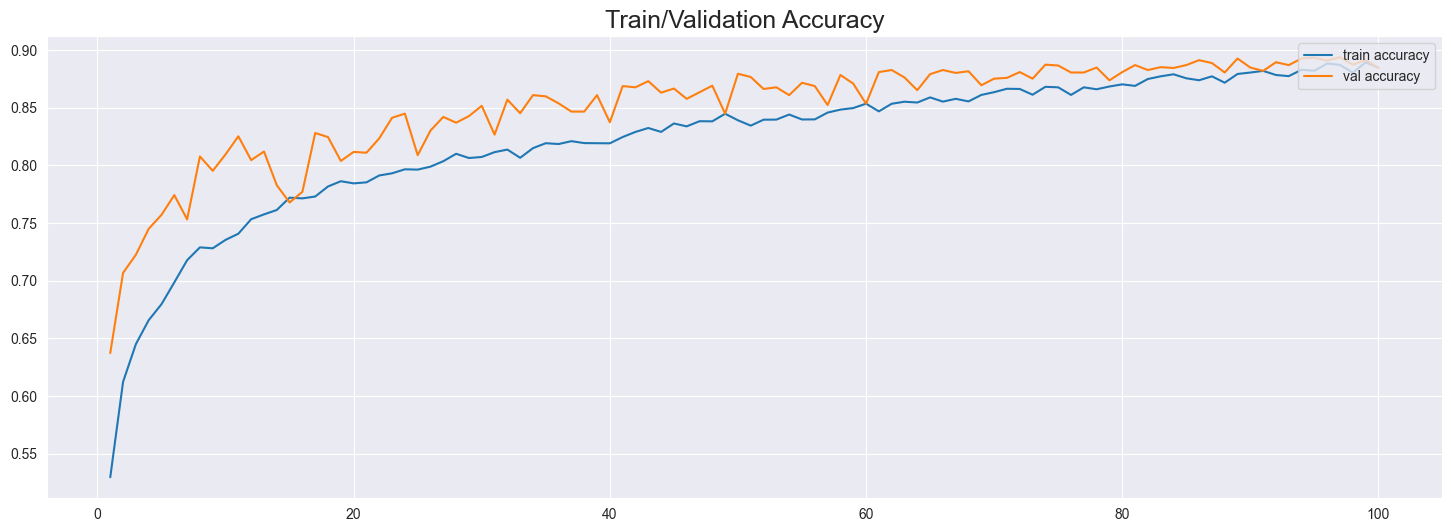

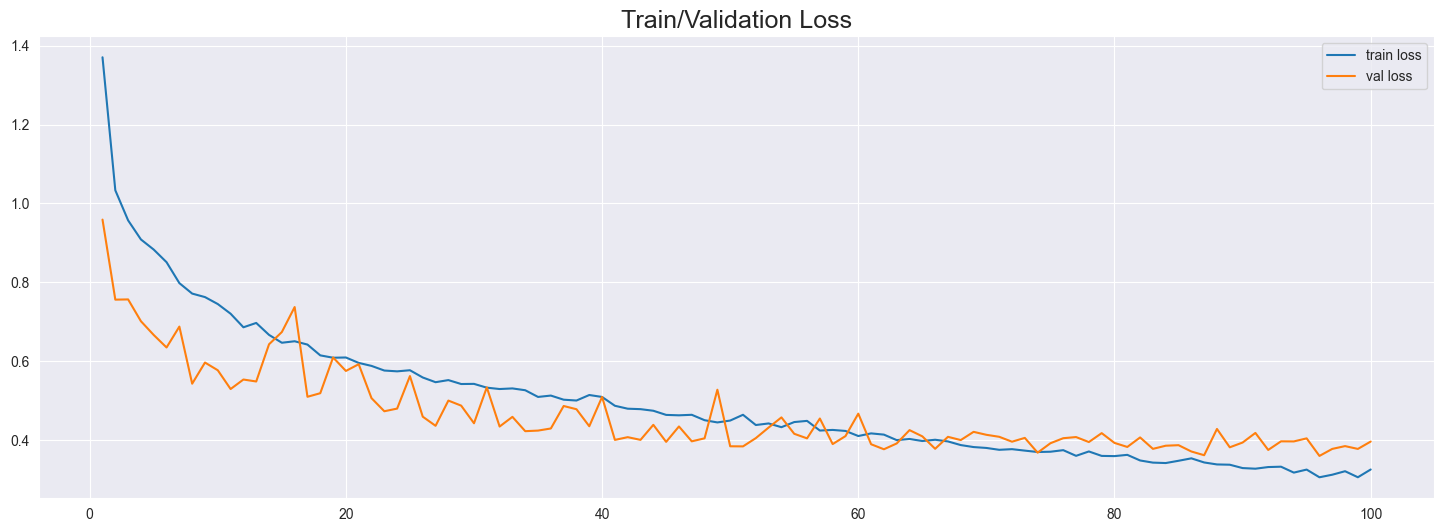

In [179]:
plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_accs, label='train accuracy')
plt.plot(range(1,EPOCHS+1), val_accs, label="val accuracy")
plt.legend(loc='upper right')
plt.title("Train/Validation Accuracy", fontsize=18)
plt.show()

plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_losses, label='train loss')
plt.plot(range(1,EPOCHS+1), val_losses, label="val loss")
plt.legend(loc='upper right')
plt.title("Train/Validation Loss", fontsize=18)
plt.show()

Save model

In [180]:
torch.save(model.state_dict(), "models/basic_CNN.pt")

Load model

In [181]:
model = CNN(num_classes=6)
model.load_state_dict(torch.load("models/basic_CNN.pt"))

<All keys matched successfully>

### Model evaluation

In [247]:
def evaluate(model, test_loader):
    '''
    computes predictions and probabilities of each prediction by batch
    :return: predictions, probs and targets
    '''
    predictions =[]
    probs = []
    targets = []
    softmax = nn.Softmax(dim=1)
    model.eval()

    for inputs, labels in test_loader:
        outputs = model(inputs)
        #compute probabilities
        y_probs = softmax(outputs)
        y_probs = y_probs.detach().numpy()
        #compute classes
        y_pred = y_probs.argmax(axis=1)

        predictions.extend(y_pred)
        probs.extend(y_probs)
        targets.extend(labels.numpy())


    return predictions, np.array(probs), targets



In [248]:
y_pred, y_probs, labels = evaluate(model, test_dataloader)

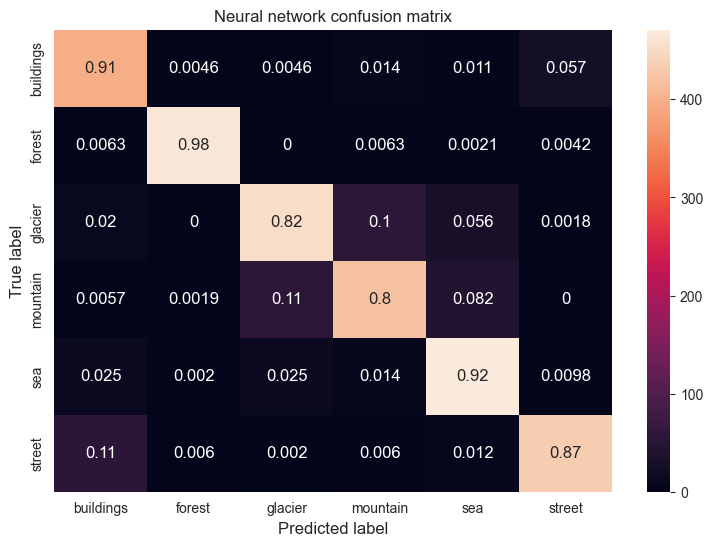

In [251]:
conf = confusion_matrix(labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=train_dataset.classes,
            xticklabels=train_dataset.classes,
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [252]:
print(classification_report(labels, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

   buildings       0.83      0.91      0.86       437
      forest       0.99      0.98      0.98       474
     glacier       0.86      0.82      0.84       553
    mountain       0.85      0.80      0.82       525
         sea       0.85      0.92      0.88       510
      street       0.93      0.87      0.90       501

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



### Roc-AUC curves

In [253]:
auc_scores = calculate_auc_scores(labels, y_probs, train_dataset.classes)

### Roc-curves for each class

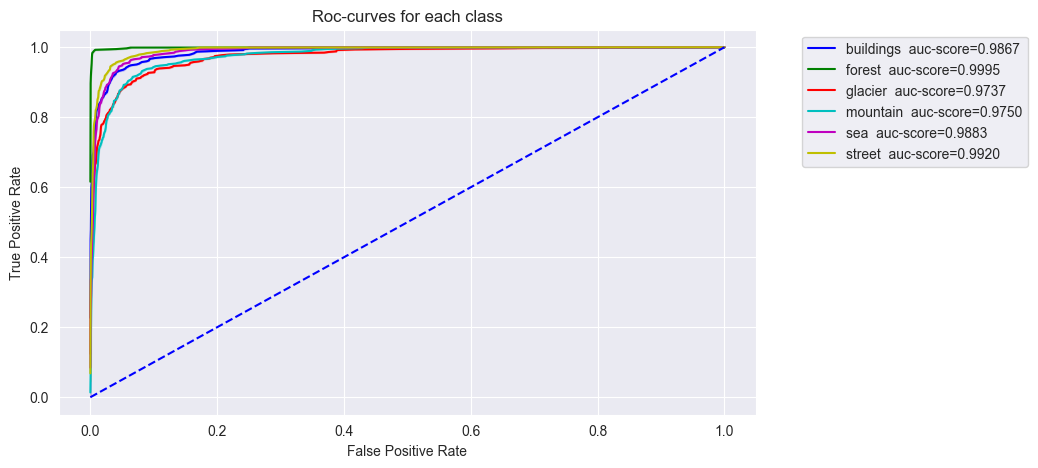

In [256]:
plot_roc_curves_ovr(labels, y_probs, train_dataset.classes, auc_scores)

### Precision-recall curves for each class

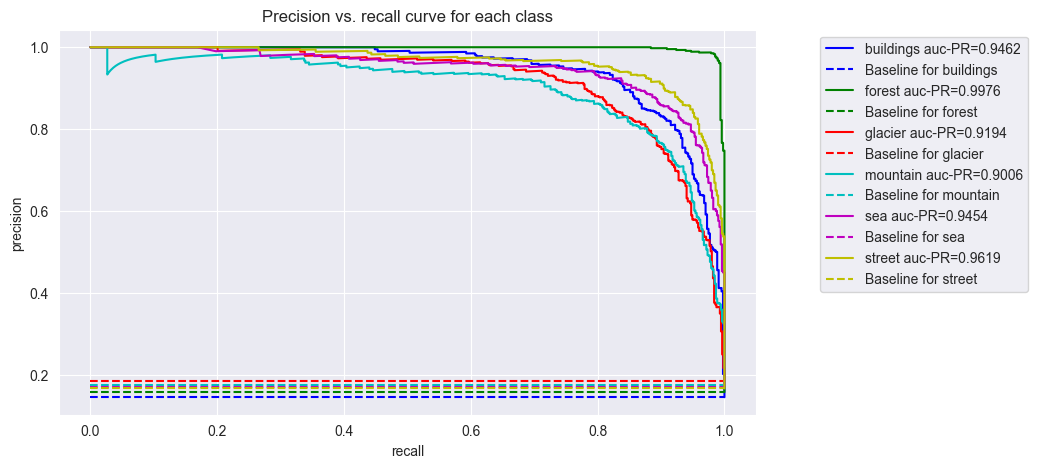

In [257]:
plot_precision_recall_curves(labels, y_probs, train_dataset.classes)

### Visualization of predictions

Show 20 random predictions from test set

In [262]:
X_test, labels = next(iter(test_dataloader))

outputs = model(X_test)
#compute probabilities
softmax = nn.Softmax(dim=1)
y_probs = softmax(outputs)
y_probs = y_probs.detach().numpy()
#compute classes
y_pred = y_probs.argmax(axis=1)

In [263]:
def show_predictions(X_test, labels, y_pred):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    plt.figure(figsize=(20, 10))
    #choose random 20 pictures
    idx = np.random.randint(0, len(X_test), 20)
    for i, index in enumerate(idx):
        ax = plt.subplot(4, 5, i + 1)
        img=X_test[index].numpy().transpose((1,2,0));
        #inverse transformation from standartization
        img=img*std+mean;
        plt.imshow(img)
        plt.title(f"Label: {train_dataset.classes[labels[index]]} \n Predicted: {train_dataset.classes[y_pred[index]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

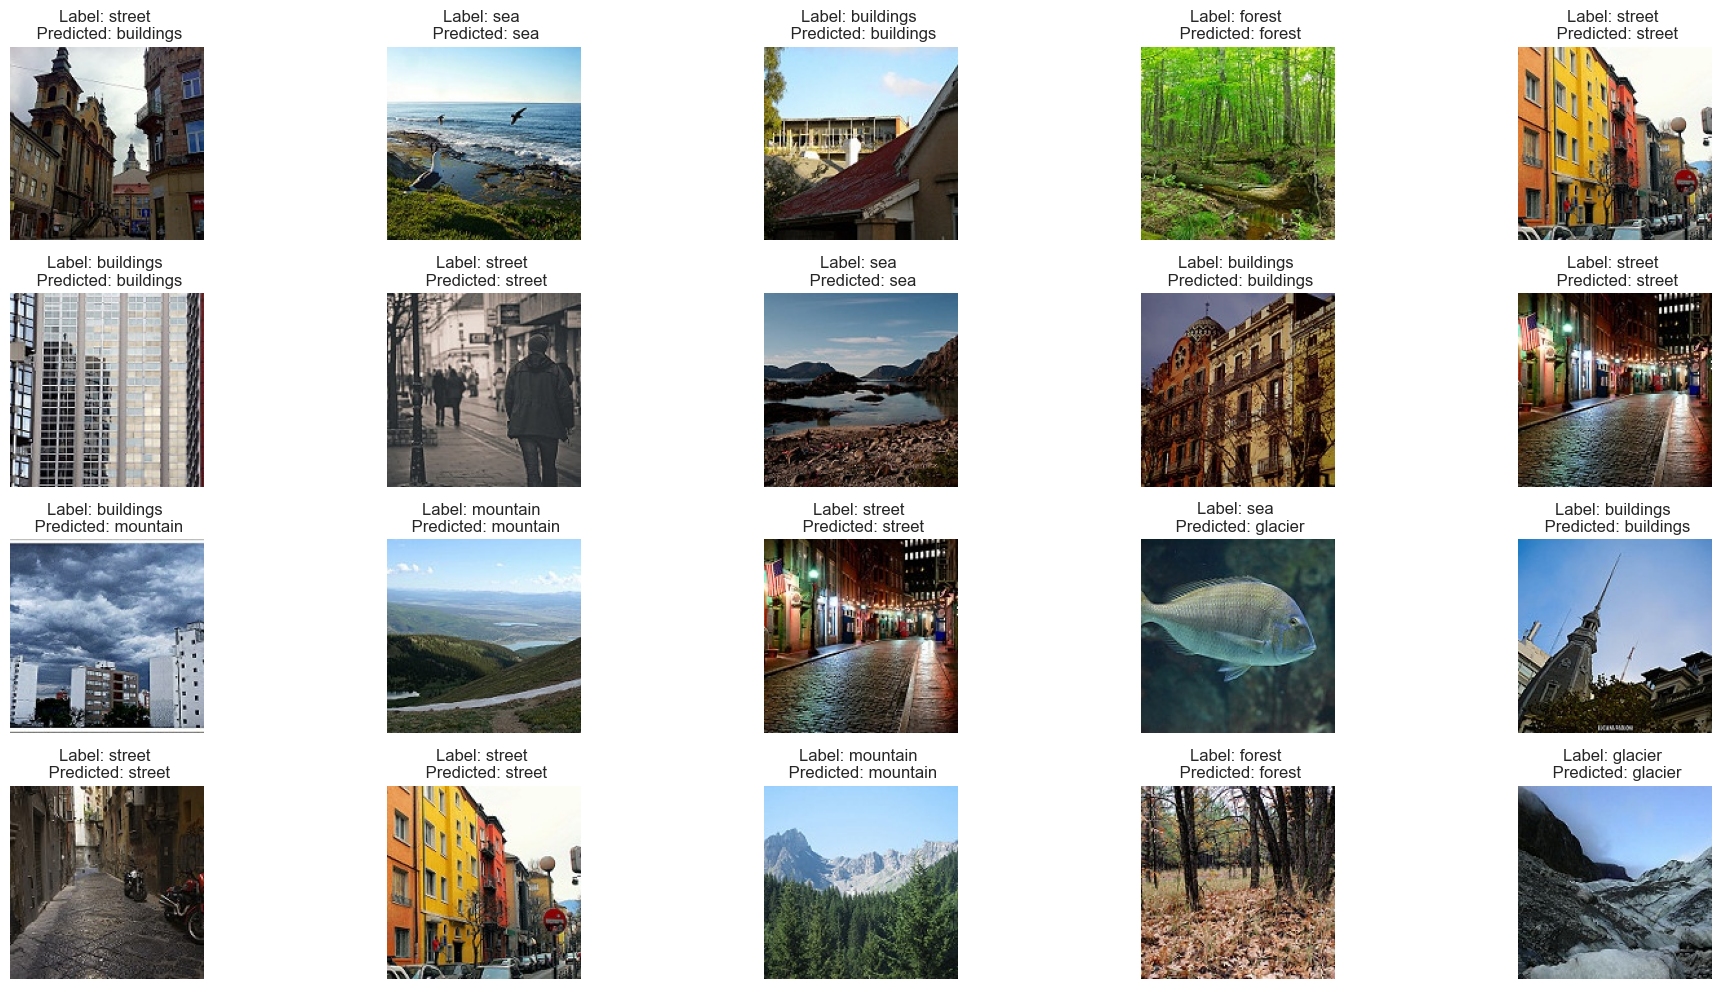

In [264]:
show_predictions(X_test, labels, y_pred)

# Fine-tuned CNN

I will use pretrained model VGG19.

In [62]:
vgg19_model = models.vgg19(pretrained=True)

In [63]:
# freeze parameters in all layers
for param in vgg19_model.parameters():
    param.requires_grad = False

In [64]:
vgg19_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [65]:
# change output features of the last classification layer to 6 classes
vgg19_model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=6, bias=True)
)

To use VGG19 I will change transformation of images: resize images from 150X150 to 224X224, as it is needed for the architecture of VGG19.

In [66]:
#transformation with augmentation
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomRotation((0,40)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop((224, 224), scale=(0.2, 1), ratio=(1, 1)),
    transforms.ToTensor(), #rescale image from (0-255) to (0,1)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalization from ImageNet
])

val_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [67]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)
val_dataset = datasets.ImageFolder(val_path, transform=val_transform)

In [68]:
BATCH_SIZE = 64

In [69]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [104]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=5, verbose=True)

In [105]:
EPOCHS = 5
train_losses, val_losses, train_accs, val_accs = train_CNN(vgg19_model, loss, optimizer, train_dataloader, val_dataloader, EPOCHS)

Epoch 1/5  Train Loss: 0.7176  Train Acc:  0.7895 Val Loss: 0.2964 Val Acc:  0.9003 Duration: 0:48:36.822921
Epoch 2/5  Train Loss: 0.4984  Train Acc:  0.8264 Val Loss: 0.2837 Val Acc:  0.9063 Duration: 0:48:50.443026
Epoch 3/5  Train Loss: 0.4938  Train Acc:  0.8278 Val Loss: 0.3168 Val Acc:  0.8933 Duration: 0:47:14.957003
Epoch 4/5  Train Loss: 0.4924  Train Acc:  0.8337 Val Loss: 0.2975 Val Acc:  0.9063 Duration: 0:46:59.369688
Epoch 5/5  Train Loss: 0.4784  Train Acc:  0.8442 Val Loss: 0.2811 Val Acc:  0.9123 Duration: 0:46:52.925205


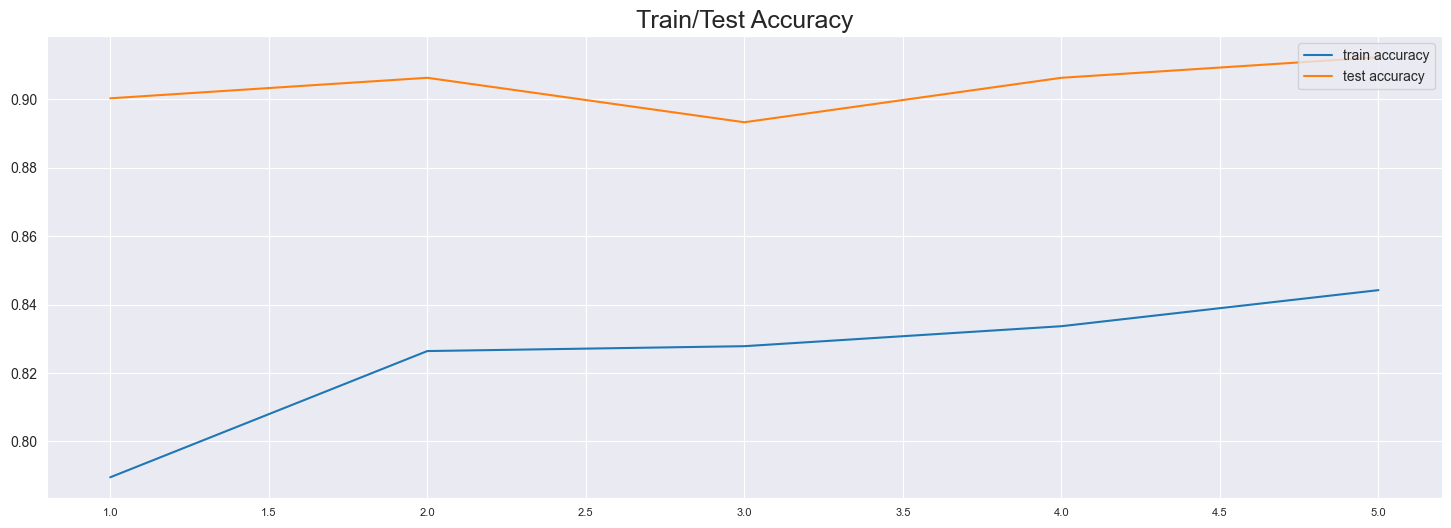

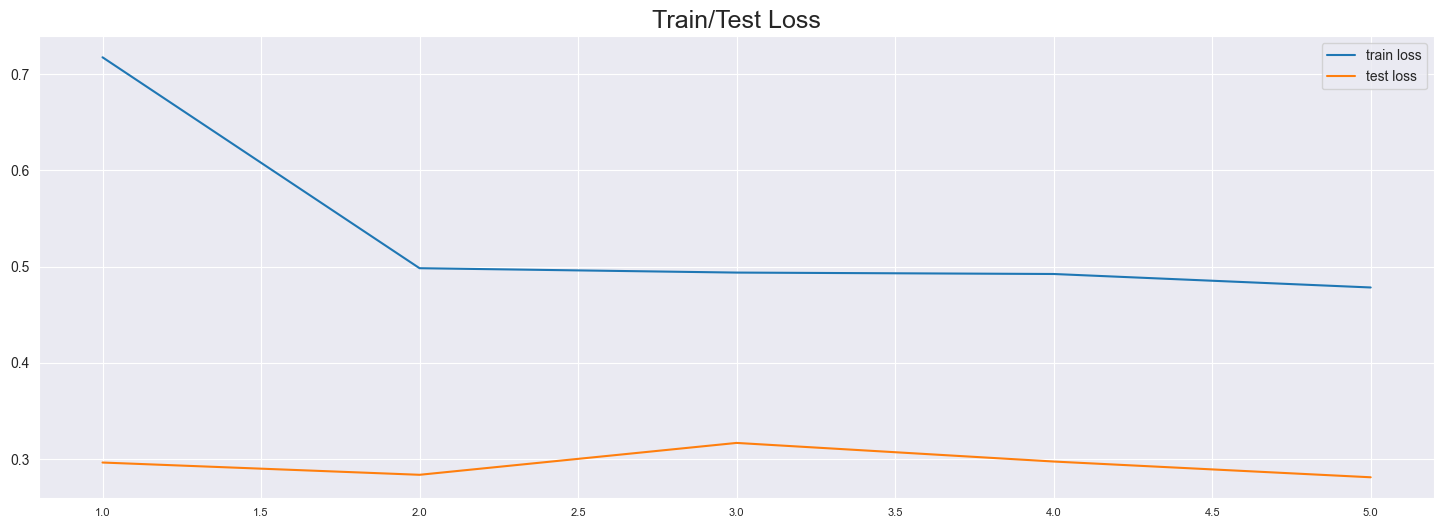

In [106]:
plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_accs, label='train accuracy')
plt.plot(range(1,EPOCHS+1), val_accs, label="val accuracy")
plt.legend(loc='upper right')
plt.title("Train/Validation Accuracy", fontsize=18)
plt.show()

plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_losses, label='train loss')
plt.plot(range(1,EPOCHS+1), val_losses, label="val loss")
plt.legend(loc='upper right')
plt.title("Train/Validation Loss", fontsize=18)
plt.show()

Save model

In [108]:
torch.save(vgg19_model.state_dict(), "models/vgg19_model.pt")

Load model

In [70]:
vgg19_model.load_state_dict(torch.load("models/vgg19_model.pt"))
vgg19_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Evaluate model on the test set

In [ ]:
y_pred, y_probs, labels = evaluate(model, test_dataloader)

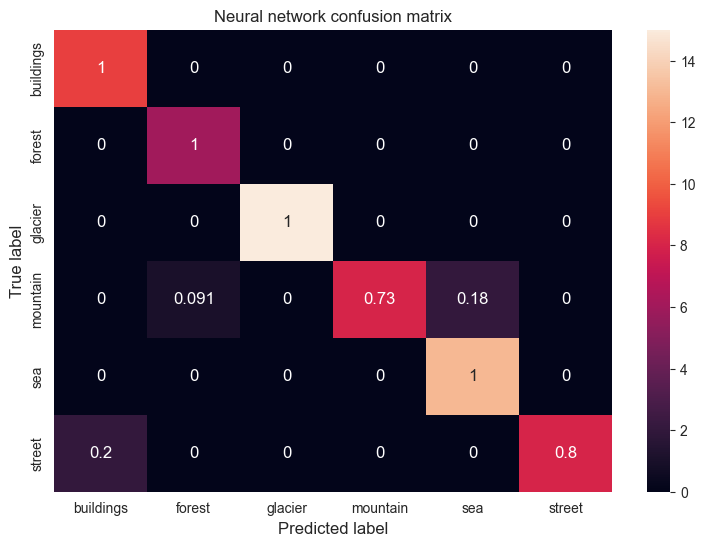

In [73]:
conf = confusion_matrix(labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=train_dataset.classes,
            xticklabels=train_dataset.classes,
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [74]:
print(classification_report(labels, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

   buildings       0.82      1.00      0.90         9
      forest       0.86      1.00      0.92         6
     glacier       1.00      1.00      1.00        15
    mountain       1.00      0.73      0.84        11
         sea       0.87      1.00      0.93        13
      street       1.00      0.80      0.89        10

    accuracy                           0.92        64
   macro avg       0.92      0.92      0.91        64
weighted avg       0.93      0.92      0.92        64



### Roc-curves for each class

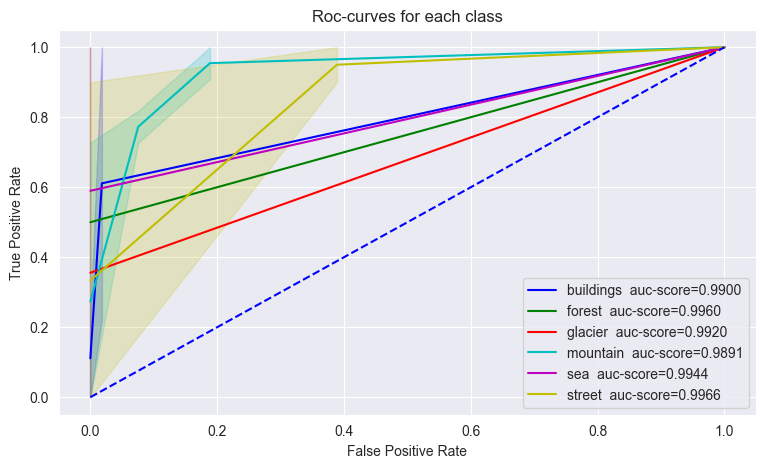

In [75]:
plot_roc_curves_ovr(X_test, labels, y_probs, train_dataset.classes, auc_scores)

### Precision-recall curves for each class

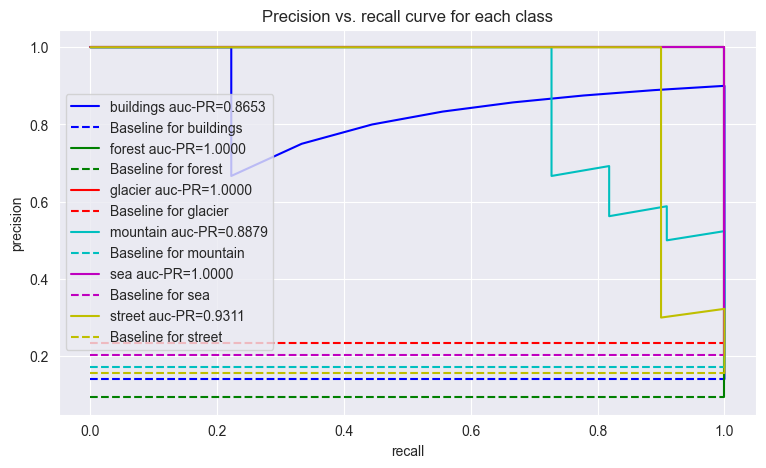

In [76]:
plot_precision_recall_curves(labels, y_probs, train_dataset.classes)

### Visualization of predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

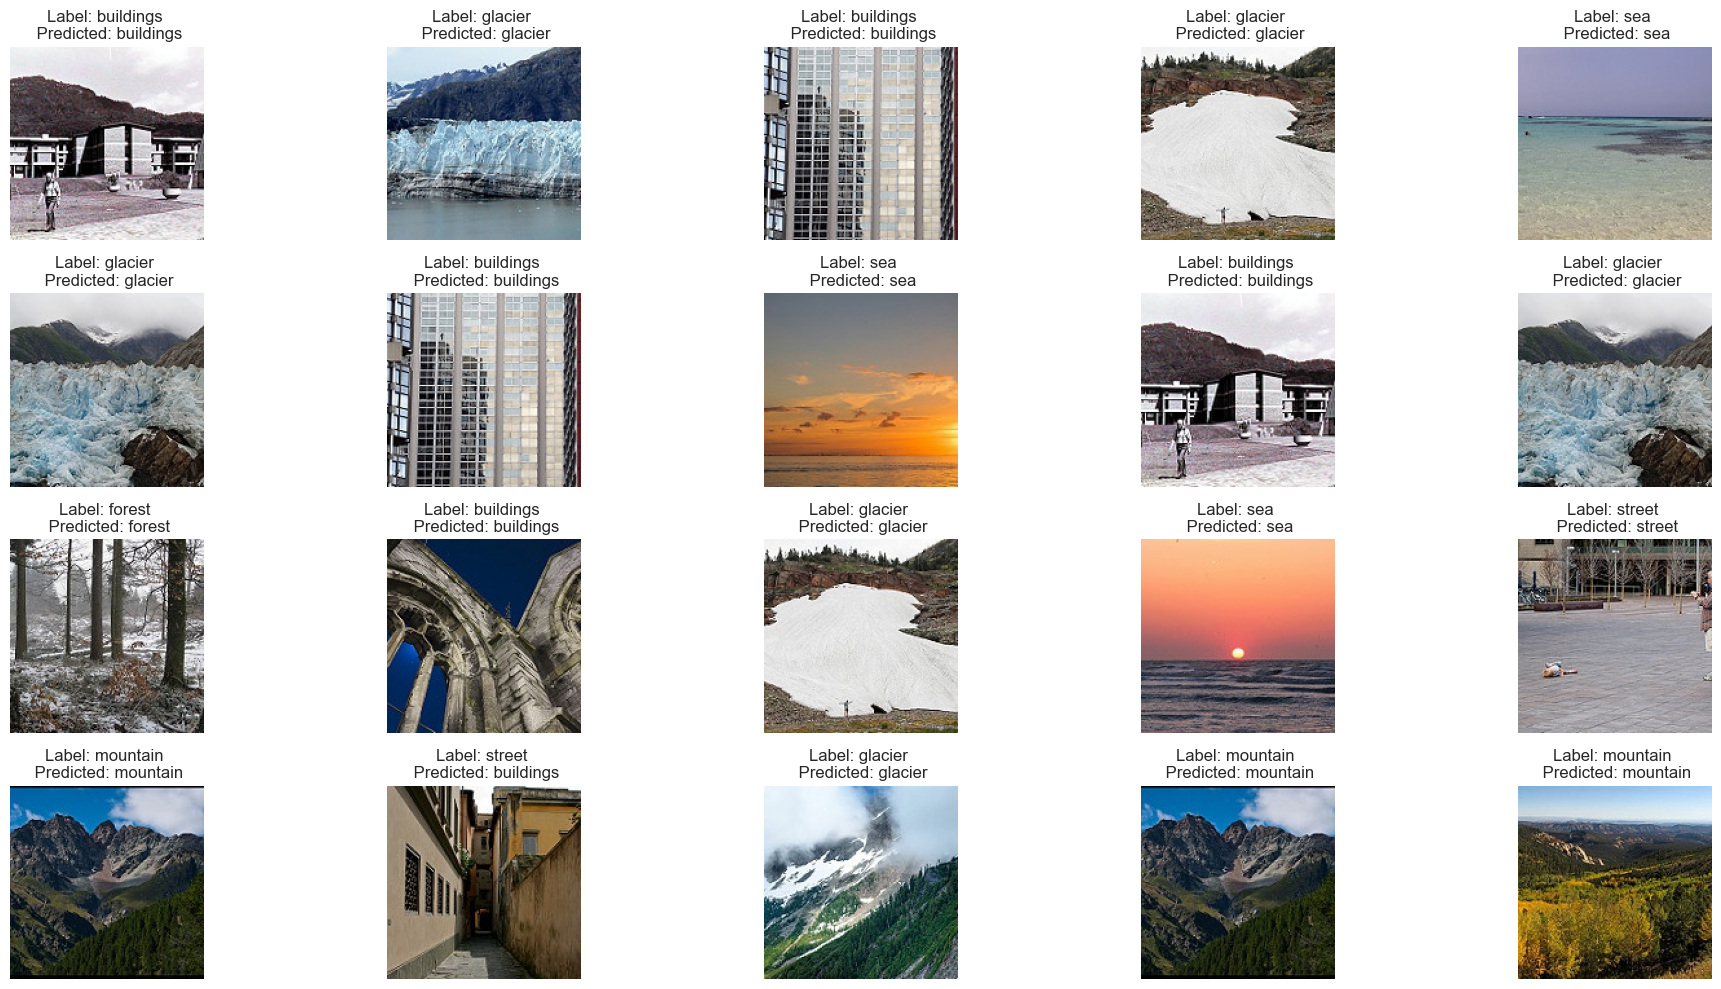

In [77]:
show_predictions(X_test, labels, y_pred)